# Identifying ghost hotels

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import re
from pysal.lib import weights

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances_chunked

In [2]:
norm_df = pd.read_csv('https://github.com/jreades/i2p/blob/master/data/clean/2020-08-24-listings-with-nlp-subset.csv.gz?raw=true',
                compression='gzip', dtype={'id':np.float64, 'listing_url':str, 'name':str, 'description':str, 'description_norm':str})
ref_df = pd.read_csv('https://github.com/jreades/i2p/blob/master/data/src/2020-08-24-listings.csv.gz?raw=true',
                    compression='gzip', usecols=['id', 'room_type', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'host_id', 'host_name', 'availability_365', 'latitude', 'longitude', 'price', 'number_of_reviews_ltm'],
                    dtype={'id':np.float64,
                           'room_type':str, 
                           'calculated_host_listings_count':np.float64,
                           'calculated_host_listings_count_entire_homes':np.float64,
                           'host_id':np.float64, 
                           'host_name':str, 
                           'availability_365':np.float64,
                           'latitude':np.float64,
                          'longitude':np.float64,
                          'price':str,
                          'number_of_reviews_ltm':np.float64})

In [4]:
df = pd.merge(norm_df, ref_df, on='id') #default is inner so we leave it
df.drop(df[(df.room_type == 'Hotel room') |
           (df.id.isna()) |
           (df.calculated_host_listings_count.isna()) |
           (df.latitude.isna())].index, inplace=True)

#Converting columns
df['price'] = df['price'].str.replace('$','').str.replace(',','').astype('float')
ints = ['id', 'host_id', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'availability_365', 'number_of_reviews_ltm']
for i in ints:
    print(f"Converting {i}")
    try:
        df[i] = df[i].astype('int')
    except ValueError as e:
        print("\tConverting to unsigned 16-bit integer.")
        df[i] = df[i].astype(pd.UInt16Dtype())

#Setting custom index
df.set_index('id', inplace=True)

#Dropping non-revenue generating listings
df.drop(df[df['number_of_reviews_ltm'] < 1].index, inplace=True)

potential_ghosts = df[(df['calculated_host_listings_count_entire_homes'] >= 2) &
                   (df['room_type'] == 'Entire home/apt') &
                   (~df['description_norm'].isna())].copy()

print(f'There are {potential_ghosts.shape[0]} candidates for ghost listings, which make up {(potential_ghosts.shape[0]/df.shape[0])*100:.2f}% of revenue-generating listings in London.')

Converting id
Converting host_id
Converting calculated_host_listings_count
Converting calculated_host_listings_count_entire_homes
Converting availability_365
Converting number_of_reviews_ltm
There are 9424 candidates for ghost listings, which make up 28.06% of revenue-generating listings in London.


In [5]:
corpus = potential_ghosts.description_norm.values
vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,2), max_df=0.5, min_df=0.05)
#ignore terms that appear in over 50% or less than 5% of documents
tcorpus = vectorizer.fit_transform(corpus).toarray() 
#fit creates list of words/ngrams + IDF scores
#transform creates matrix of TF/IDF scores per word/ngram
#convert to array for cosine similarity step

In [6]:
keys = potential_ghosts.index
cosine_distances = pd.DataFrame(squareform(pdist(tcorpus, metric='cosine')), index=keys, columns=keys)

In [7]:
#Individual listings that meet criteria
ghost_listings = cosine_distances[(cosine_distances < 0.2).sum(1) > 2].index.tolist()

#Extract clusters of listings that have similar descriptions to over 2 other listings
#2 because 1 will always be the listing itself, and the other could be another spare room in an apartment
ghost_clusters = cosine_distances[(cosine_distances < 0.2).sum(1) > 2].apply(lambda row: row[row < 0.2].index.tolist(), 1).tolist()

In [30]:
#Creating distance band weights for ghost listings
#1. Convert original df to gdf and reproject so it's in BNG
gdf = gpd.GeoDataFrame(df, 
      geometry=gpd.points_from_xy(df['longitude'], df['latitude'], crs='epsg:4326'))
boros = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')
gdf = gdf.to_crs(boros.crs)

In [31]:
#Create separate df of ghost listings
ghost_gdf = gdf.loc[ghost_listings].copy()
test_dbw = weights.DistanceBand.from_dataframe(ghost_gdf, 300)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 209 disconnected components.
 There are 58 islands with ids: 2157833, 2157875, 5489380, 5804727, 9527125, 11490518, 12279193, 15716630, 15825519, 15867303, 17920357, 20594689, 20900549, 21033839, 22950731, 26411989, 26759848, 27558897, 28599788, 29841567, 31129560, 31371504, 31372980, 34133919, 34780610, 35701543, 35864176, 36007147, 36017633, 36056404, 36221501, 36512875, 36618215, 36638322, 36750006, 36756071, 37046662, 37581725, 37831106, 37983314, 38014300, 38445377, 38532525, 38558564, 38899011, 38918439, 39213589, 39625402, 39856155, 40025338, 40584466, 41809358, 41900914, 42403476, 42503583, 42760282, 44096370, 44099917.
  warnings.warn(message)


In [27]:
listing_clusters = list(zip(ghost_listings, ghost_clusters))
sorted(listing_clusters, key=lambda x: len(x[1]), reverse=True)

In [187]:
ghost_hotels = set()
seen = set() #set of elements that have already been in a cluster

for l, c in sorted(listing_clusters, key=lambda x: len(x[1]), reverse=True):
    if l not in seen: #if the listing is not already in a cluster
        hotel = set(c) & set(test_dbw[l]) #create set of elements that are both similar and neighbours
        if (len(hotel) > 1) & (len(hotel & seen) == 0): #if there is more than one element in the hotel set,
            #and no elements in the hotel set have already been seen,
            hotel.add(l) #add the listing to the hotel, bc the original set wouldnt have it
            ghost_hotels.add(frozenset(hotel)) #freeze the hotel set and add to super-set of ghost hotels
            for i in hotel: 
                seen.add(i) #add each element in the hotel set to the set of listings already in clusters
                #we're assuming that the longest listing clusters will contain all potential subsets that could include a listing

In [234]:
entire_homes = df[df['room_type'] == 'Entire home/apt'].shape[0]
print(f'There are {len(seen)} listings in {len(ghost_hotels)} suspected ghost hotels, which account for {(len(seen)/entire_homes)*100:.2f}% of revenue-generating entire home listings in London.')

There are 2141 listings in 426 suspected ghost hotels, which account for 10.81% of revenue-generating entire home listings in London.


In [220]:
sorted(list(ghost_hotels), key=len, reverse=True)[:6]

[frozenset({31826559, 32009228, 33700605}),
 frozenset({33793180, 33794280, 37609471}),
 frozenset({18683864, 18703075, 20911184}),
 frozenset({19289385, 32122595, 33331940}),
 frozenset({11389487, 27598715, 42190468}),
 frozenset({32010389, 34456467, 34456554})]

In [226]:
gdf.loc[[32010389, 34456467, 34456554]]

,listing_url,name,description,description_norm,host_id,host_name,latitude,longitude,room_type,price,availability_365,number_of_reviews_ltm,calculated_host_listings_count,calculated_host_listings_count_entire_homes,geometry
id,,,,,,,,,,,,,,,
32010389,https://www.airbnb.com/rooms/32010389,💖 Central Modern Westminster Apartment ★★★★★ R1,★★★★★ SUPERB LOCATION - moments away from West...,superb location moment away westminster abbey ...,205479296,Simon,51.49200,-0.13320,Entire home/apt,15.07,335,8,8,8,POINT (529697.689 178657.990)
34456467,https://www.airbnb.com/rooms/34456467,💖 Central Modern Westminster Apartment ★★★★★ R1,★★★★★ SUPERB LOCATION - moments away from West...,superb location moment away westminster abbey ...,205479296,Simon,51.49182,-0.13318,Entire home/apt,80.02,335,17,8,8,POINT (529699.588 178638.009)
34456554,https://www.airbnb.com/rooms/34456554,💖 Central Modern Westminster Apartment ★★★★★ R1,★★★★★ SUPERB LOCATION - moments away from West...,superb location moment away westminster abbey ...,205479296,Simon,51.49182,-0.13318,Entire home/apt,14.00,336,1,8,8,POINT (529699.588 178638.009)


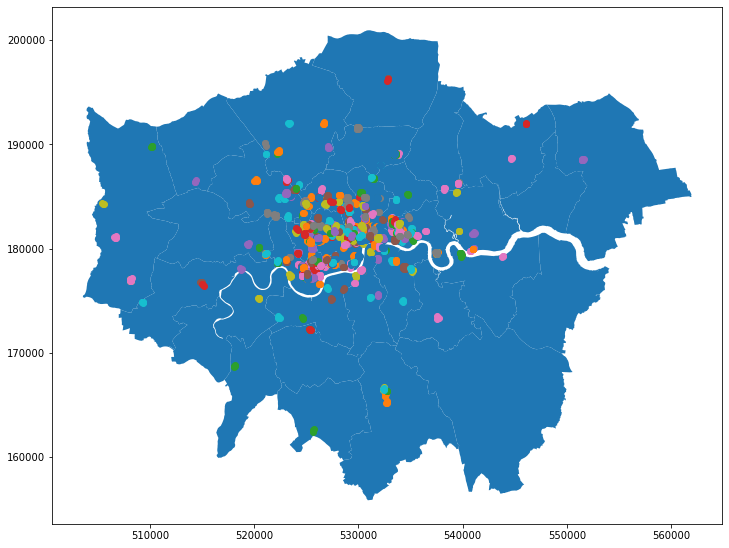

In [171]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
boros.plot(ax=ax)
for h in ghost_hotels:
    gdf.loc[h].plot(ax=ax)